In [5]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from umap import UMAP

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [6]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/cluster/Sex_ukb_OLS_FColl-SRh_right_with-residualization.csv"
label = "Sex"
covariates = ["Age", "BrainVolumeFreeSurfer_mm3"]
max_iter = 2000
cv = 3

In [7]:
participants = pd.read_csv(participants_file, index_col=0)
participants.head()

,Sex,Age,BrainVolumeFreeSurfer_mm3,Ageattendedimaging,ImagingName,isBigBrain,isOld
participant_id,,,,,,,
sub-3411469,1,65.0,1136465.0,65.0,Cheadle,NaN,NaN
sub-2290292,0,69.0,1079118.0,69.0,Newcastle,NaN,NaN
sub-3842391,0,70.0,1124077.0,70.0,Cheadle,NaN,NaN
sub-2758537,1,49.0,1246758.0,49.0,Newcastle,NaN,0.0
sub-4334619,1,70.0,1410387.0,70.0,Cheadle,1.0,NaN


In [8]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [9]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [10]:
participants = participants[[label] + covariates].dropna()

array([[<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'BrainVolumeFreeSurfer_mm3'}>, <Axes: >]],
      dtype=object)

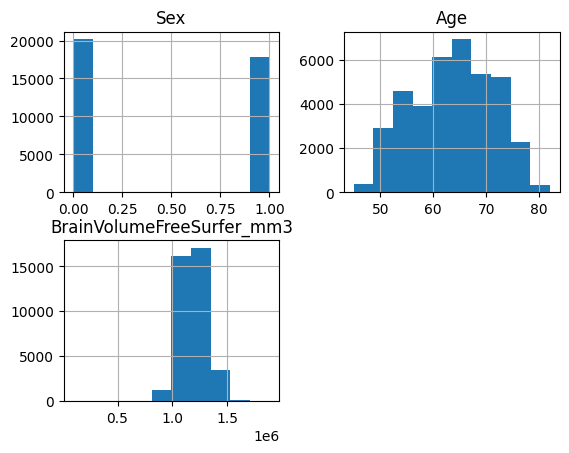

In [11]:
participants.hist()

In [12]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [13]:
model_paths = get_model_paths(path_champollion)

In [14]:
model_paths = [m for m in model_paths if "FColl-SRh_right" in m ]

In [15]:
model_paths

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [16]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)

    # Residualizes
    phenotypes_cols = embeddings.columns
    merged = participants[covariates].merge(embeddings, left_index=True, right_index=True)
    resid_df = merged[covariates].copy()
    resid_df.loc[:, phenotypes_cols] = 0.0
    for dim_i in phenotypes_cols:
        X = merged[covariates]
        X = sm.add_constant(X)
        y = merged[dim_i]
        model = sm.OLS(y, X).fit()
        residuals = model.resid
        resid_df.loc[:, dim_i] = residuals
        # ypred = model.predict(X)
        # residuals2 = y - ypred

        # print(f"diff residuals = {((residuals2-residuals)**2).sum()}")

    # Merge
    merged = participants[[label]].merge(resid_df[phenotypes_cols], left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    ypred = results.predict(df2)
    f_value = results.fvalue
    p_value = results.f_pvalue

    # df = Y.copy()
    # df["predicted"] = df2.dot(results.params)
    # # predicted = pd.DataFrame(model.predict(results.params), columns=["predicted"])
    # # predicted = sm.add_constant(predicted)
    # # predicted.index = Y.index
    # # print(predicted[:5])
    # results = sm.OLS(df[label], 2*df["predicted"]).fit()

    # print(results.summary())
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path), merged, ypred

In [17]:
results = []
for model_path in model_paths:
    result, merged, ypred = compute(model_path)
    results.append(result)

Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
12.600221074850879


In [18]:
merged0 = merged.copy()
merged0.insert(0, "ypred", ypred)

<Axes: xlabel='ypred', ylabel='Count'>

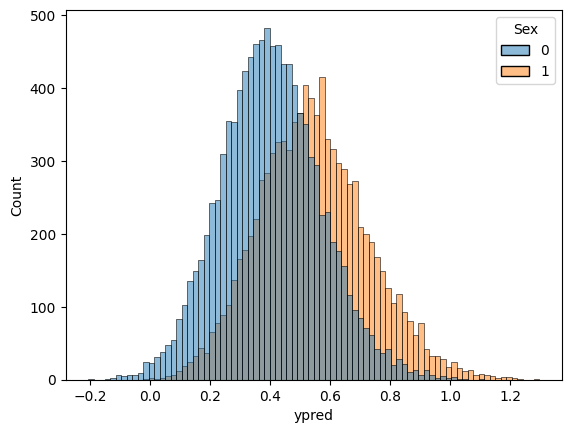

In [19]:
sns.histplot(merged0, x="ypred", hue="Sex")

In [20]:
merged.insert(0, "ypred", ypred)


In [21]:
merged["ypred"] = [0 if x < 0.35 else 1 if x > 0.55 else np.nan for x in merged["ypred"]]

In [22]:
merged

,ypred,Sex,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-3411469,1.0,1,47.248189,-57.937783,48.397560,15.832503,48.291619,15.527507,23.934634,47.192190,...,-10.327442,-20.794098,82.606095,90.712208,51.502263,-36.870491,-4.975549,-11.000219,-3.052587,17.104024
sub-2290292,0.0,0,29.057069,57.391311,1.635332,-16.794841,1.710299,-37.344744,-8.632563,8.119588,...,26.552817,-13.686836,17.665731,-20.491513,-15.791228,-6.664802,19.172479,-19.820423,29.845673,4.912950
sub-4334619,0.0,1,-19.621373,38.617504,-58.819185,-16.783163,-11.212827,23.032183,2.921374,-77.974235,...,-22.271532,9.566611,-28.759560,-51.685395,-32.409656,41.077051,-8.419394,46.422028,-6.447899,-5.922961
sub-1188492,NaN,0,-62.108381,44.109347,20.976197,30.864380,24.892608,-11.035538,2.392878,65.443623,...,5.247304,-21.638339,-29.367447,33.079620,24.740855,-37.553196,-11.082888,-50.372132,-11.167268,-5.722141
sub-3798925,NaN,0,23.457717,-48.680801,30.781465,55.712051,-28.238186,5.493941,10.551601,-46.511770,...,-1.335673,57.700894,35.934457,7.175526,-36.513167,-28.592103,-7.759832,25.467317,39.183864,12.567106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5405288,NaN,1,-51.486387,-24.685874,40.409717,75.144471,18.344849,2.533727,2.781220,26.185327,...,-20.978808,11.862844,5.209246,21.406163,49.984168,5.257802,-13.932804,7.374770,-10.476676,30.334623
sub-5206663,1.0,0,-11.104440,-49.754398,32.969858,-0.401105,-46.017866,27.341788,22.003685,-33.302664,...,31.033767,-1.056077,-28.721248,55.569735,-9.570202,39.847223,5.331118,37.042947,26.039065,-15.137531
sub-1895291,0.0,0,-42.937903,61.833158,-37.976900,6.343157,34.555325,-9.295992,-46.492297,-25.827690,...,37.482814,19.284876,-51.186459,7.618332,-13.113023,14.783824,-0.804472,-14.538348,7.107921,-35.222098
sub-2621329,1.0,1,-88.722596,-27.123597,40.643010,-40.870803,-24.514942,-27.928577,-3.067293,8.273720,...,35.383643,-8.144071,57.294744,14.978269,-18.479090,12.268923,-5.536099,5.452424,22.298253,18.335979


In [23]:
def compute_umap(df, n_neighbors=15, n_components=2):
    # apply umap
    reducer = UMAP(n_neighbors=n_neighbors, n_components=n_components)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [24]:
merged.iloc[:,2:]

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-3411469,47.248189,-57.937783,48.397560,15.832503,48.291619,15.527507,23.934634,47.192190,-9.550826,38.189882,...,-10.327442,-20.794098,82.606095,90.712208,51.502263,-36.870491,-4.975549,-11.000219,-3.052587,17.104024
sub-2290292,29.057069,57.391311,1.635332,-16.794841,1.710299,-37.344744,-8.632563,8.119588,-17.388451,31.197273,...,26.552817,-13.686836,17.665731,-20.491513,-15.791228,-6.664802,19.172479,-19.820423,29.845673,4.912950
sub-4334619,-19.621373,38.617504,-58.819185,-16.783163,-11.212827,23.032183,2.921374,-77.974235,11.437417,-19.176476,...,-22.271532,9.566611,-28.759560,-51.685395,-32.409656,41.077051,-8.419394,46.422028,-6.447899,-5.922961
sub-1188492,-62.108381,44.109347,20.976197,30.864380,24.892608,-11.035538,2.392878,65.443623,32.516611,-2.294467,...,5.247304,-21.638339,-29.367447,33.079620,24.740855,-37.553196,-11.082888,-50.372132,-11.167268,-5.722141
sub-3798925,23.457717,-48.680801,30.781465,55.712051,-28.238186,5.493941,10.551601,-46.511770,2.300245,21.929691,...,-1.335673,57.700894,35.934457,7.175526,-36.513167,-28.592103,-7.759832,25.467317,39.183864,12.567106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5405288,-51.486387,-24.685874,40.409717,75.144471,18.344849,2.533727,2.781220,26.185327,-4.133799,19.601474,...,-20.978808,11.862844,5.209246,21.406163,49.984168,5.257802,-13.932804,7.374770,-10.476676,30.334623
sub-5206663,-11.104440,-49.754398,32.969858,-0.401105,-46.017866,27.341788,22.003685,-33.302664,-82.114419,-36.625445,...,31.033767,-1.056077,-28.721248,55.569735,-9.570202,39.847223,5.331118,37.042947,26.039065,-15.137531
sub-1895291,-42.937903,61.833158,-37.976900,6.343157,34.555325,-9.295992,-46.492297,-25.827690,-38.027872,-25.486292,...,37.482814,19.284876,-51.186459,7.618332,-13.113023,14.783824,-0.804472,-14.538348,7.107921,-35.222098
sub-2621329,-88.722596,-27.123597,40.643010,-40.870803,-24.514942,-27.928577,-3.067293,8.273720,-0.470560,49.051354,...,35.383643,-8.144071,57.294744,14.978269,-18.479090,12.268923,-5.536099,5.452424,22.298253,18.335979


In [25]:
visual, _ = compute_umap(merged.iloc[:,2:])

/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


<Axes: xlabel='vis0', ylabel='vis1'>

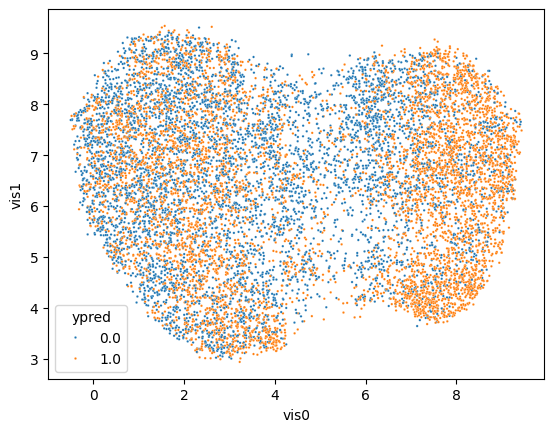

In [26]:
visual_df = merged[[label, "ypred"]].copy()
visual_df[["vis0", "vis1"]] = visual
sns.scatterplot(data=visual_df, x="vis0", y="vis1", hue="ypred", s=3)

<Axes: xlabel='vis0', ylabel='vis1'>

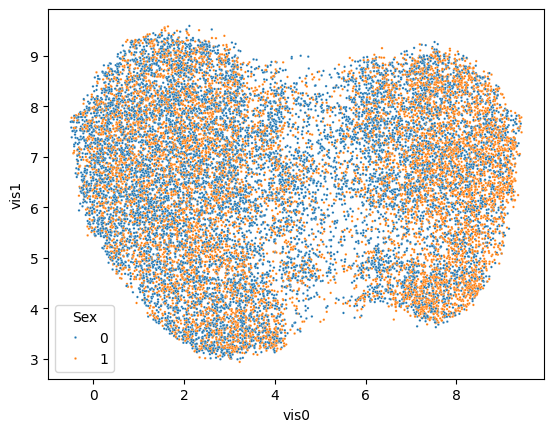

In [27]:
sns.scatterplot(data=visual_df, x="vis0", y="vis1", hue=label, s=3)

In [28]:
visual_df

,Sex,ypred,vis0,vis1
sub-3411469,1,1.0,7.333162,4.158069
sub-2290292,0,0.0,3.173053,3.712766
sub-4334619,1,0.0,1.671211,7.522194
sub-1188492,0,NaN,6.300942,7.550714
sub-3798925,0,NaN,1.163919,6.718856
...,...,...,...,...
sub-5405288,1,NaN,7.204911,6.730652
sub-5206663,0,1.0,1.718730,8.814661
sub-1895291,0,0.0,2.140048,8.532356
sub-2621329,1,1.0,8.301385,8.845877


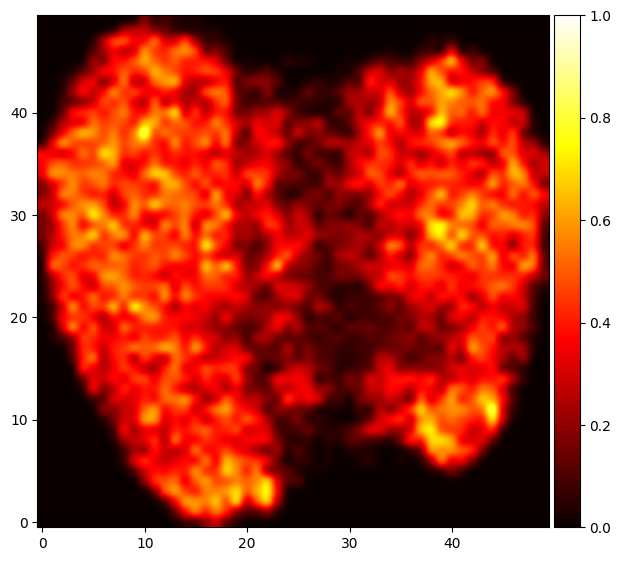

In [29]:
fig, ax = plt.subplots(figsize=[7,10], ncols=1)


# Plots heatmap
Z, xedges, yedges = np.histogram2d(visual_df["vis0"], visual_df["vis1"], bins=50, density=True)
Z = Z/np.unique(Z)[-1]
im = ax.imshow(Z.T,
          origin='lower',
          cmap='hot', 
          interpolation='gaussian'
          )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = fig.colorbar(im, cax=cax)

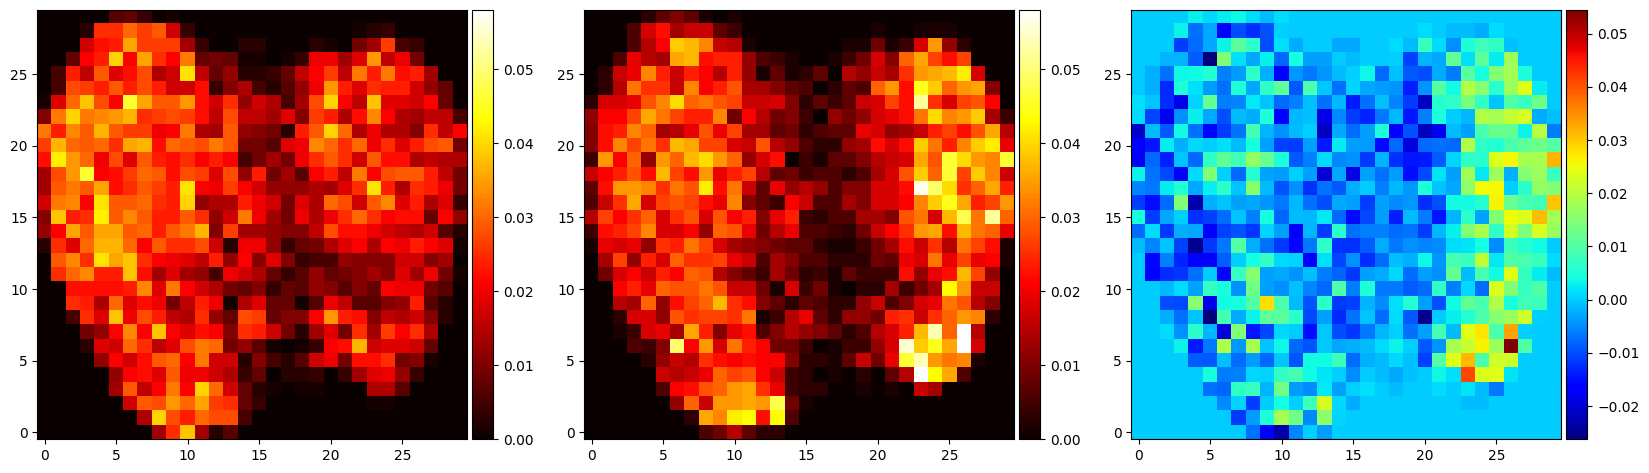

In [30]:
fig, ax = plt.subplots(figsize=[20,10], ncols=3)


# Plots heatmap of females
females = visual_df[visual_df[label]==0]
Z, xedges, yedges = np.histogram2d(females["vis0"], females["vis1"], bins=30, density=True)
# Zf = Z/np.unique(Z)[-1]
Zf = Z
im = ax[0].imshow(Zf.T,
          origin='lower',
          cmap='hot', 
          interpolation='none',
          vmax=0.058
          )
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = plt.colorbar(im, cax=cax)

# Plots heatmap of males
males = visual_df[visual_df[label]==1]
Z, xedges, yedges = np.histogram2d(males["vis0"], males["vis1"], bins=30, density=True)
# Zm = Z/np.unique(Z)[-1]
Zm = Z
im = ax[1].imshow(Zm.T,
          origin='lower',
          cmap='hot', 
          interpolation='none',
          vmax=0.058
          )
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = plt.colorbar(im, cax=cax)

# Plots heatmap of differenc
Z = Zm-Zf
im = ax[2].imshow(Z.T,
          origin='lower',
          cmap='jet', 
          interpolation='none'
          )

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = fig.colorbar(im, cax=cax)

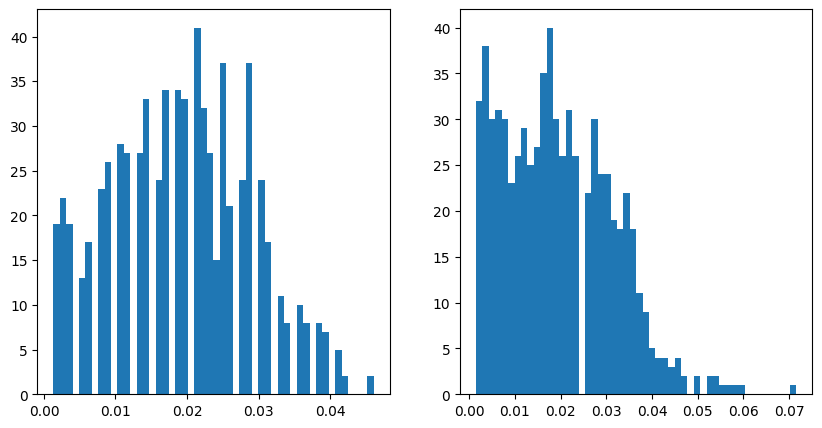

In [31]:
fig, ax = plt.subplots(figsize=[10,5], ncols=2)
p = ax[0].hist(Zf[Zf!=0].flatten(), bins=50)
p = ax[1].hist(Zm[Zm!=0].flatten(), bins=50)

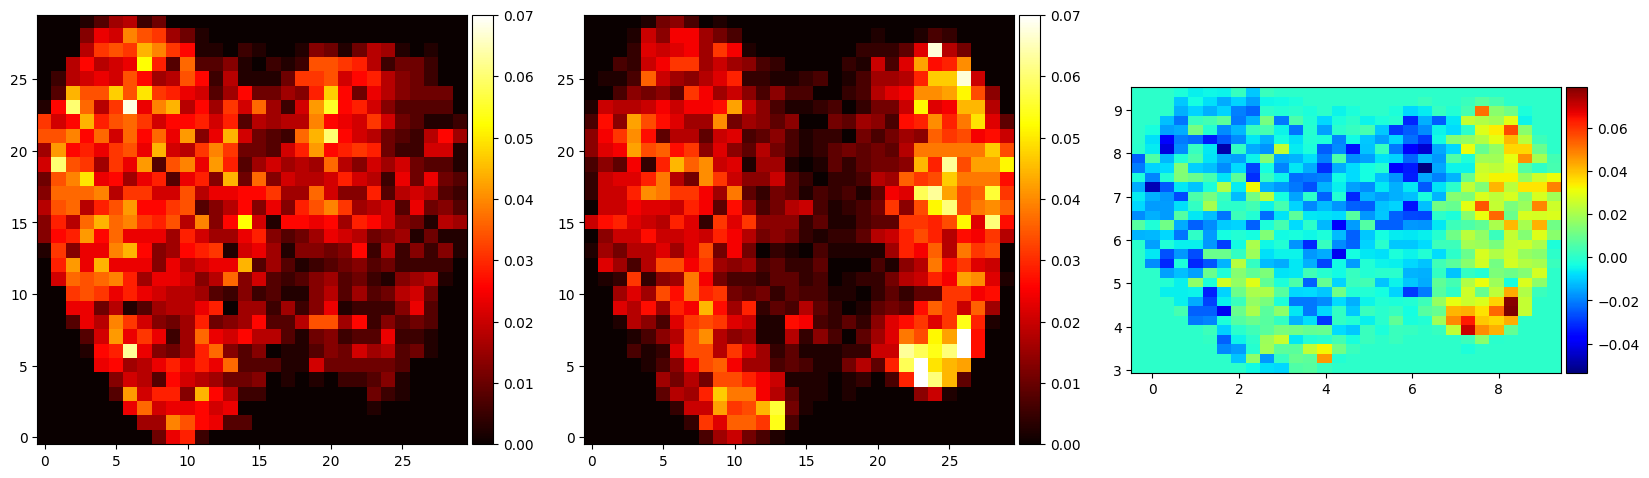

In [32]:
fig, ax = plt.subplots(figsize=[20,10], ncols=3)


# Plots heatmap of females
females = visual_df[visual_df["ypred"]==0]
Z, xedges, yedges = np.histogram2d(females["vis0"], females["vis1"], bins=30, density=True)
# Zf = Z/np.unique(Z)[-1]
Zf = Z
im = ax[0].imshow(Zf.T,
          origin='lower',
          cmap='hot', 
          interpolation='none',
          vmax=0.07
          )
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = plt.colorbar(im, cax=cax)

# Plots heatmap of males
males = visual_df[visual_df["ypred"]==1]
Z, xedges, yedges = np.histogram2d(males["vis0"], males["vis1"], bins=30, density=True)
# Zm = Z/np.unique(Z)[-1]
Zm = Z
im = ax[1].imshow(Zm.T,
          origin='lower',
          cmap='hot', 
          interpolation='none',
          vmax=0.07
          )
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = plt.colorbar(im, cax=cax)

# Plots heatmap of difference
Z = Zm-Zf
im = ax[2].imshow(Z.T,
          origin='lower',
          cmap='jet', 
          interpolation='none',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
          )

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = fig.colorbar(im, cax=cax)

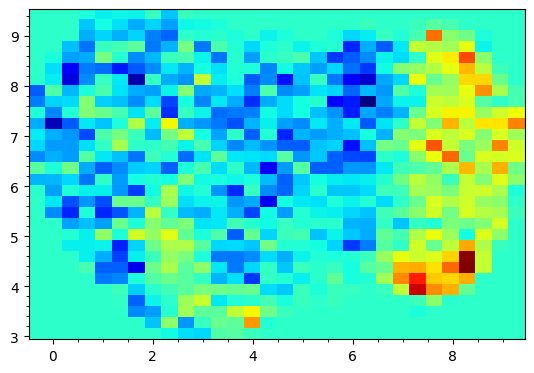

In [33]:
# Plots heatmap of difference
Z = Zm-Zf
im = plt.imshow(Z.T,
          origin='lower',
          cmap='jet', 
          interpolation='none',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
          )
plt.minorticks_on()

In [34]:
visual_df.insert(0, "cluster", 0)

In [35]:
x = visual_df["vis0"]
y = visual_df["vis1"]
conditions = [
      (x < 0.5) & (y > 6.2) & (y < 8),
      (x > 3.5) & (x < 4.5) & (y > 5) & (y < 6.2),
      (x > 5.4) & (x < 6.5) & (y > 5.8) & (y < 8.6),
      (x > 8.5) & (y > 5.6) & (y < 7.4),
      (x > 6.2) & (x < 9) & (y > 3.2) & (y < 4.4)
]
choices = [1, 2, 3, 4, 5]

visual_df["cluster"] = np.select(conditions, choices, 0)

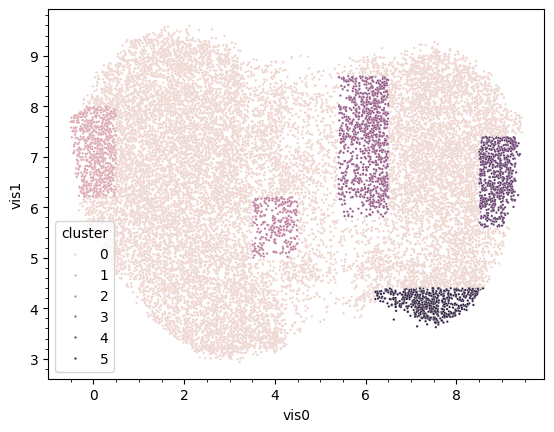

In [36]:
sns.scatterplot(data=visual_df, x="vis0", y="vis1", hue="cluster", s=3)
plt.minorticks_on()

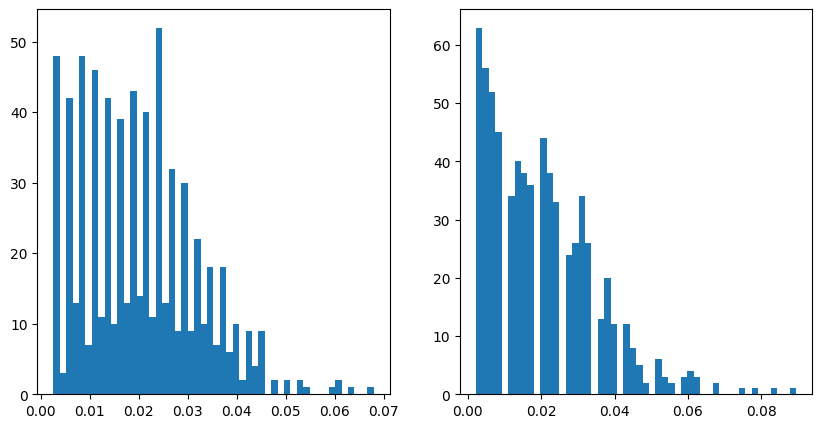

In [37]:
fig, ax = plt.subplots(figsize=[10,5], ncols=2)
p = ax[0].hist(Zf[Zf!=0].flatten(), bins=50)
p = ax[1].hist(Zm[Zm!=0].flatten(), bins=50)

<Axes: xlabel='vis0', ylabel='Density'>

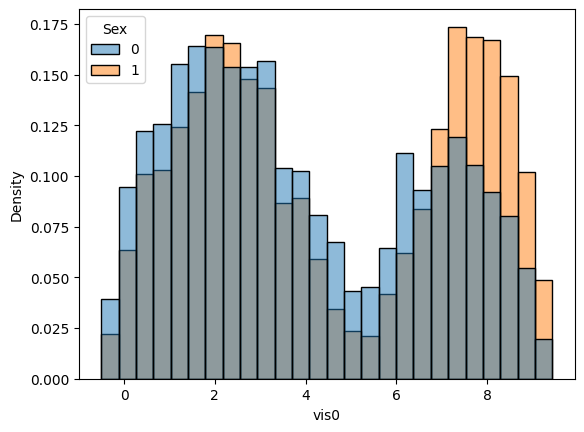

In [69]:
sns.histplot(data=visual_df, x="vis0", hue=label, stat="density", common_norm=False)

<Axes: xlabel='vis0', ylabel='Density'>

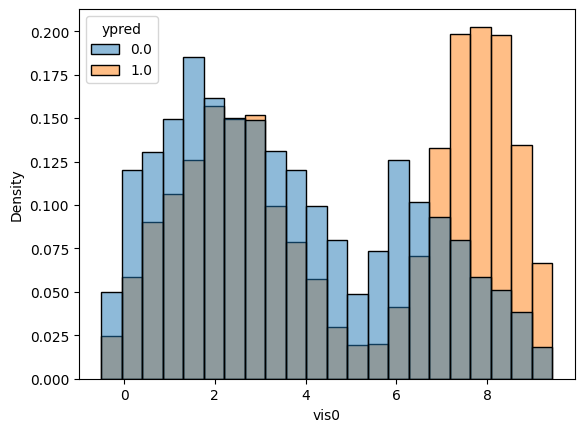

In [70]:
sns.histplot(data=visual_df, x="vis0", hue="ypred", stat="density", common_norm=False)

<Axes: xlabel='vis1', ylabel='Density'>

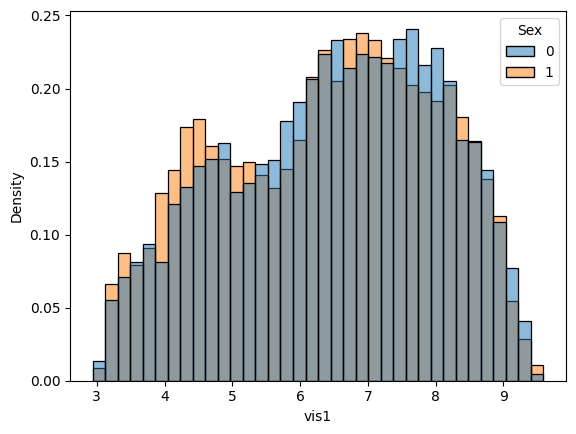

In [71]:
sns.histplot(data=visual_df, x="vis1", hue=label, stat="density", common_norm=False)

<Axes: xlabel='vis1', ylabel='Density'>

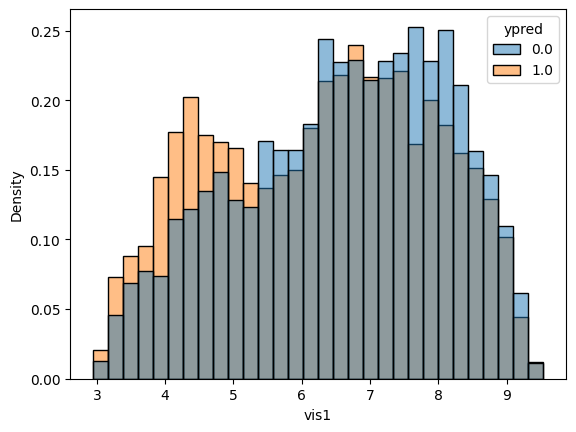

In [72]:
sns.histplot(data=visual_df, x="vis1", hue="ypred", stat="density", common_norm=False)

In [41]:
visual_df

,cluster,Sex,ypred,vis0,vis1
sub-3411469,5,1,1.0,7.333162,4.158069
sub-2290292,0,0,0.0,3.173053,3.712766
sub-4334619,0,1,0.0,1.671211,7.522194
sub-1188492,3,0,NaN,6.300942,7.550714
sub-3798925,0,0,NaN,1.163919,6.718856
...,...,...,...,...,...
sub-5405288,0,1,NaN,7.204911,6.730652
sub-5206663,0,0,1.0,1.718730,8.814661
sub-1895291,0,0,0.0,2.140048,8.532356
sub-2621329,0,1,1.0,8.301385,8.845877


<Axes: xlabel='vis0', ylabel='ypred'>

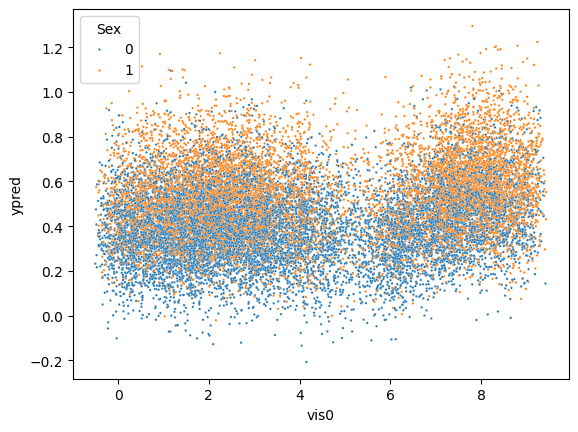

In [42]:
visual_df0 = merged0[[label, "ypred"]].copy()
visual_df0[["vis0", "vis1"]] = visual
sns.scatterplot(data=visual_df0, x="vis0", y="ypred", hue="Sex", s=3)

<Axes: xlabel='vis1', ylabel='ypred'>

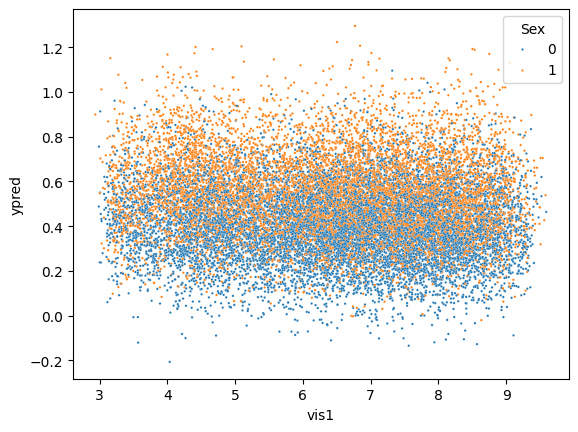

In [43]:
sns.scatterplot(data=visual_df0, x="vis1", y="ypred", hue="Sex", s=3)

# Où se situent les petits cerveaux?

In [53]:
participants = pd.read_csv(participants_file, index_col=0)
visual_df_complete = visual_df.merge(participants[["isBigBrain", "isOld"]], left_index=True, right_index=True)
visual_df_complete = visual_df_complete.rename(columns={"ypred": "ypred_binary"})
visual_df_complete = visual_df_complete.merge(merged0[["ypred"]], left_index=True, right_index=True)
visual_df_complete

,cluster,Sex,ypred_binary,vis0,vis1,isBigBrain,isOld,ypred
sub-3411469,5,1,1.0,7.333162,4.158069,NaN,NaN,0.715684
sub-2290292,0,0,0.0,3.173053,3.712766,NaN,NaN,0.207720
sub-4334619,0,1,0.0,1.671211,7.522194,1.0,NaN,0.127384
sub-1188492,3,0,NaN,6.300942,7.550714,0.0,NaN,0.397132
sub-3798925,0,0,NaN,1.163919,6.718856,NaN,0.0,0.469513
...,...,...,...,...,...,...,...,...
sub-5405288,0,1,NaN,7.204911,6.730652,NaN,NaN,0.445227
sub-5206663,0,0,1.0,1.718730,8.814661,NaN,0.0,0.687110
sub-1895291,0,0,0.0,2.140048,8.532356,0.0,NaN,0.221406
sub-2621329,0,1,1.0,8.301385,8.845877,NaN,NaN,0.820713


<Axes: xlabel='vis0', ylabel='vis1'>

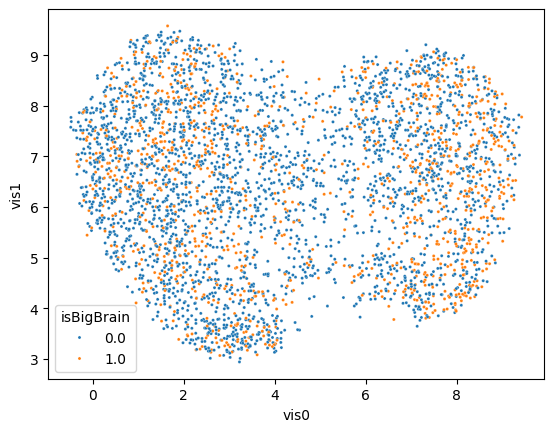

In [49]:
sns.scatterplot(data=visual_df_complete, x="vis0", y="vis1", hue="isBigBrain", s=5)

<Axes: xlabel='ypred', ylabel='Density'>

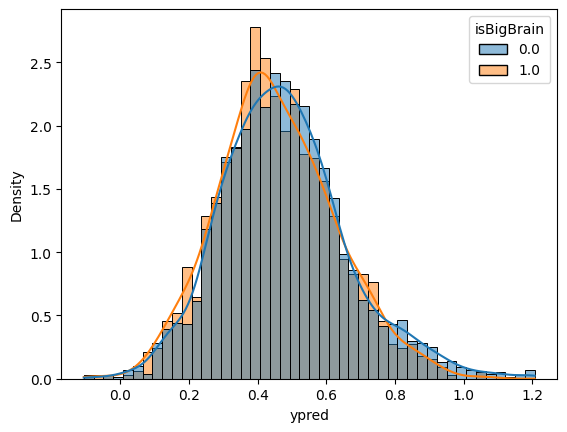

In [66]:
sns.histplot(data=visual_df_complete, x="ypred", hue="isBigBrain", kde=True, common_norm=False, stat="density")

<Axes: xlabel='vis0', ylabel='vis1'>

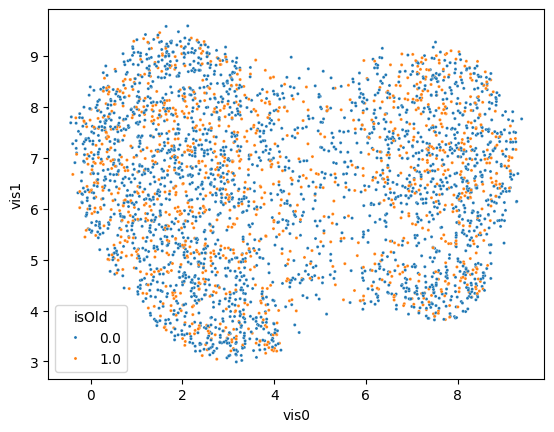

In [50]:
sns.scatterplot(data=visual_df_complete, x="vis0", y="vis1", hue="isOld", s=5)

<Axes: xlabel='ypred', ylabel='Density'>

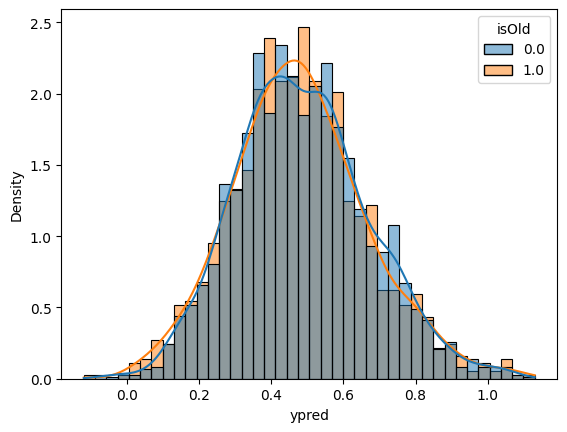

In [73]:
sns.histplot(data=visual_df_complete, x="ypred", hue="isOld", common_norm=False, kde=True, stat='density')